# Start of the lab 03
#### By Haeffner Edwin and Junod Arthur

## Concatenation of the two dataframes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl

mice_eeg1 = pd.read_csv('./pw3_data/EEG_mouse_data_1.csv')
mice_eeg2 = pd.read_csv('./pw3_data/EEG_mouse_data_2.csv')

mice_eeg = pd.concat([mice_eeg1, mice_eeg2], axis=0)
mice_eeg = np.array(mice_eeg)



## KFold grouping

In [2]:
from keras import layers
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import tensorflow.keras as keras

scaler = StandardScaler()

#normalize data
input_data = mice_eeg[:,1:26]
input_data = input_data.astype('float32')

output_data = mice_eeg[:,0:1]

output_data[output_data == 'w'] = 1.
output_data[output_data == 'n'] = -1.
output_data[output_data == 'r'] = -1.

output_data = output_data.astype('float32')

pl.clf()

keras.utils.set_random_seed(123)
kf = KFold(n_splits=3, shuffle=True)

for i, (train_index, test_index) in enumerate(kf.split(mice_eeg)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")
    

2024-04-19 14:41:44.929682: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Fold 0:
  Train: index=[    0     2     3 ... 40860 40861 40862]
  Test:  index=[    1     8    15 ... 40854 40856 40857]
Fold 1:
  Train: index=[    0     1     4 ... 40859 40860 40862]
  Test:  index=[    2     3     5 ... 40855 40858 40861]
Fold 2:
  Train: index=[    1     2     3 ... 40857 40858 40861]
  Test:  index=[    0     4     6 ... 40859 40860 40862]


<Figure size 640x480 with 0 Axes>

## Data normalization

In [3]:
from sklearn.utils import class_weight

def create_model():
    # Calculate class weights
    class_weights = class_weight.compute_class_weight('balanced', np.unique(output_data), output_data)
    class_weights = dict(enumerate(class_weights))
    
    mlp = keras.Sequential([
        layers.Input(25),
        layers.Dense(32, activation="tanh"),
        layers.Dense(32, activation="tanh"),
        layers.Dense(3)
    ])

    mlp.compile(
        optimizer=keras.optimizers.SGD(learning_rate=0.001, momentum=0.8),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"]
    )

    # Set class weights during training
    mlp.fit(..., class_weight=class_weights)

    return mlp

mlp = create_model()
mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                832       
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,921
Trainable params: 1,921
Non-trainable params: 0
_________________________________________________________________


2024-04-19 14:41:48.518267: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [4]:
from sklearn.preprocessing import LabelEncoder

# Encode the states into asleep (-1) and awake (1)


history_list = []
trained_mlp = []
history = []

mice_eeg = np.array(mice_eeg)

for i, (train_index, test_index) in enumerate(kf.split(input_data)):
    scaler = StandardScaler()
    # We need to create a new model everytime otherwise fit will continue previous training
    mlp = create_model()
    
    history = mlp.fit(
        x=scaler.fit_transform(input_data[train_index]), y=output_data[train_index],
        validation_data=(scaler.transform(input_data[test_index]), output_data[test_index]),
        epochs=2
    )
       
    history_list.append(history)
    trained_mlp.append(mlp)

    

Epoch 1/2
852/852 [==============================] - 8s 9ms/step - loss: 0.4020 - val_loss: 0.3521
Epoch 2/2
852/852 [==============================] - 5s 6ms/step - loss: 0.3565 - val_loss: 0.3485
Epoch 1/2
852/852 [==============================] - 5s 6ms/step - loss: 0.3809 - val_loss: 0.3615
Epoch 2/2
852/852 [==============================] - 6s 8ms/step - loss: 0.3506 - val_loss: 0.3582
Epoch 1/2
852/852 [==============================] - 8s 9ms/step - loss: 0.4078 - val_loss: 0.3567
Epoch 2/2
852/852 [==============================] - 6s 7ms/step - loss: 0.3518 - val_loss: 0.3513


## Plotting the training history

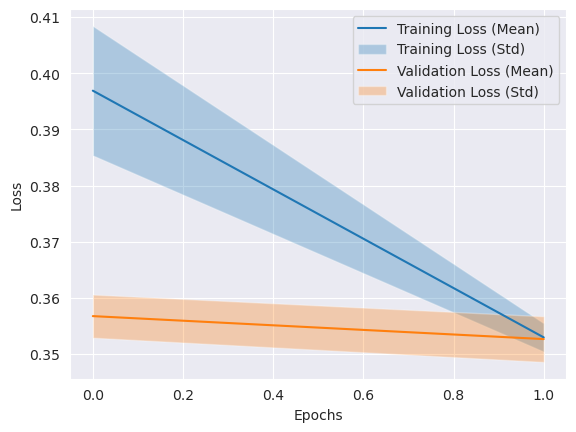

In [5]:
train_losses = np.array([history.history['loss'] for history in history_list])
val_losses = np.array([history.history['val_loss'] for history in history_list])

# Calculate mean and standard deviation for training and validation losses
mean_train_loss = np.mean(train_losses, axis=0)
std_train_loss = np.std(train_losses, axis=0)
mean_val_loss = np.mean(val_losses, axis=0)
std_val_loss = np.std(val_losses, axis=0)

# Plot mean and standard deviation for training loss
pl.plot(mean_train_loss, label='Training Loss (Mean)')
pl.fill_between(range(len(mean_train_loss)), mean_train_loss - std_train_loss, mean_train_loss + std_train_loss, alpha=0.3, label='Training Loss (Std)')

# Plot mean and standard deviation for validation loss
pl.plot(mean_val_loss, label='Validation Loss (Mean)')
pl.fill_between(range(len(mean_val_loss)), mean_val_loss - std_val_loss, mean_val_loss + std_val_loss, alpha=0.3, label='Validation Loss (Std)')

# Add labels and legend
pl.xlabel('Epochs')
pl.ylabel('Loss')
pl.legend()

# Display the plot
pl.show()

426/426 [==============================] - 3s 6ms/step


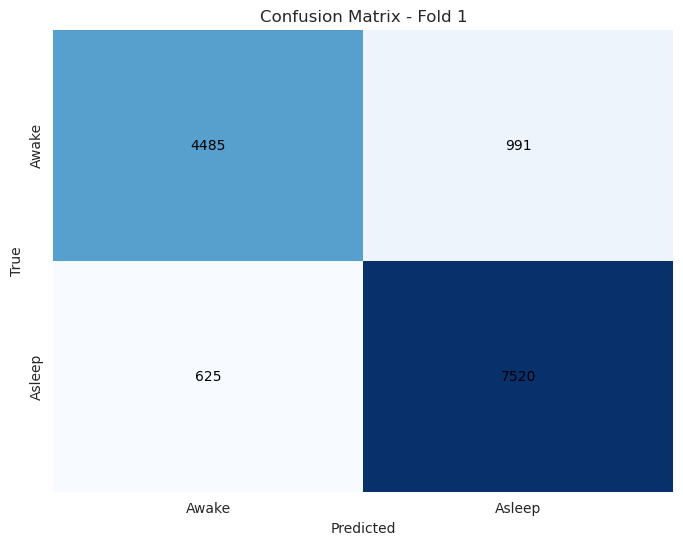

F1 Score - Fold 1: 0.9029779058597502
426/426 [==============================] - 3s 6ms/step


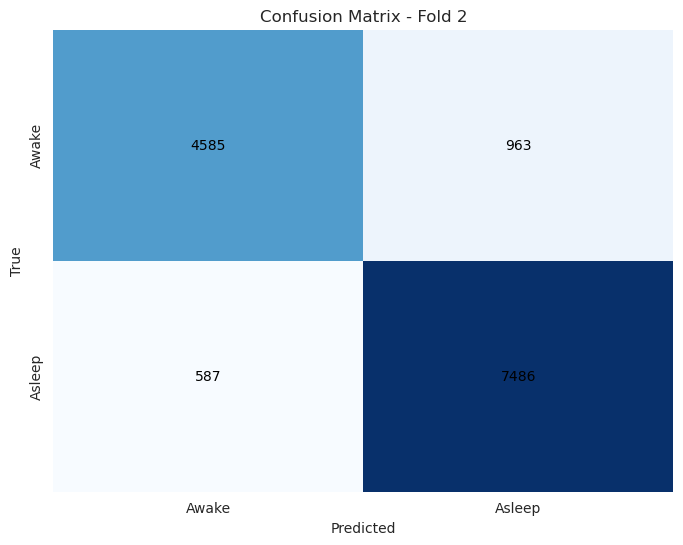

F1 Score - Fold 2: 0.9061856918048662
426/426 [==============================] - 2s 5ms/step


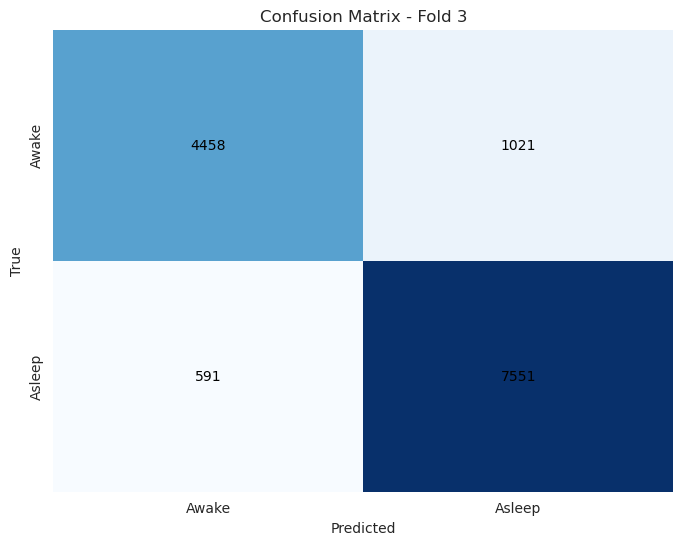

F1 Score - Fold 3: 0.9035539069043915


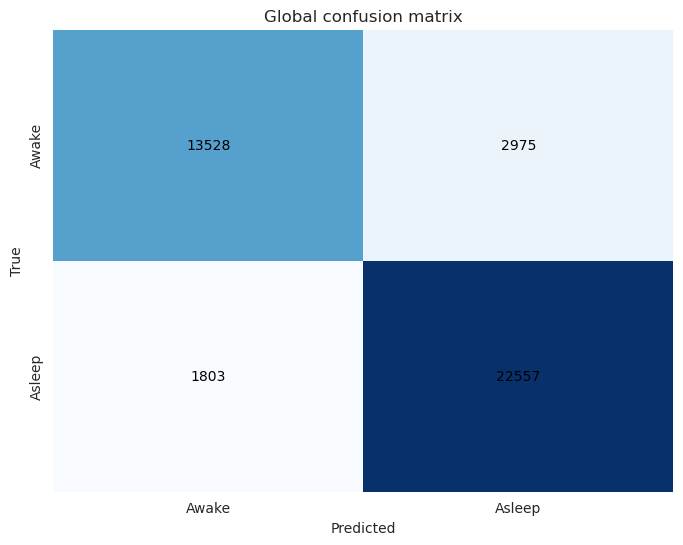

Mean F1 Score across all folds: 0.9042391681896693


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns

def plot_confusion_matrix(confusion_matrix, title, class_labels):
    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(confusion_matrix.astype(int), annot=False, fmt='', cmap="Blues", cbar=False,
                xticklabels=class_labels, yticklabels=class_labels, ax=ax)

    # Add numerical values to the heatmap
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            x = j + 0.5  # Shift x-coordinate to center the text
            y = i + 0.5  # Shift y-coordinate to center the text
            ax.text(x, y, str(confusion_matrix[i, j]), ha="center", va="center", color="black")

    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    plt.show()
    
class_labels = ['Awake', 'Asleep']

f1_scores = []
mean_confusion_matrix = np.zeros((2, 2))

for i, (train_index, test_index) in enumerate(kf.split(input_data)):
    # Evaluate the trained model on the test fold
    predictions = (trained_mlp[i].predict(scaler.transform(input_data[test_index])) > 0).astype(int)
    true_labels = (output_data[test_index] > 0).astype(int)

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    mean_confusion_matrix += confusion_matrix(true_labels, predictions)

    # Compute confusion matrix and plot
    plot_confusion_matrix(cm, f'Confusion Matrix - Fold {i + 1}',class_labels)

    # Compute F1 score
    f1 = f1_score(true_labels, predictions)
    f1_scores.append(f1)
    print(f"F1 Score - Fold {i + 1}: {f1}")

# Plot mean confusion matrix
plot_confusion_matrix(mean_confusion_matrix.astype(int), 'Global confusion matrix', class_labels)

# Calculate and display the mean F1 score across all folds
mean_f1_score = np.mean(f1_scores)
print(f"Mean F1 Score across all folds: {mean_f1_score}")
